<https://github.com/PolymathicAI/xVal>


In [1]:
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"

In [2]:
import jax.numpy as jnp  # Oddly works in colab to set gpu

arr = jnp.array([1, 2, 3])
arr.devices()

{cuda(id=0)}

In [3]:
import icecream
from icecream import ic

icecream.install()
ic_disable = False
if ic_disable:
    ic.disable()
ic.configureOutput(includeContext=True, contextAbsPath=True)

In [4]:
import os
import ast

from datetime import datetime as dt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
import hephaestus as hp
import jax
import jax.numpy as jnp
import numpy as np
import optax
import pandas as pd
from flax.training import train_state
from icecream import ic
from jax import random
from flax import struct
from flax.training import checkpoints
from jax.tree_util import tree_flatten
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm, trange
from hephaestus.models.simple_time_series import SimpleDS

pd.options.mode.copy_on_write = True

2024-06-01 13:35:06.768301: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
def line2df(line, idx):
    data_rows = []
    line = ast.literal_eval(line)
    for i, time_step in enumerate(line["data"]):
        row = {"time_step": i}
        # Add position data for each planet
        for j, position in enumerate(time_step):
            row[f"planet{j}_x"] = position[0]
            row[f"planet{j}_y"] = position[1]
        data_rows.append(row)

    df = pd.DataFrame(data_rows)
    description = line.pop("description")
    step_size = description.pop("stepsize")
    for k, v in description.items():
        for k_prop, v_prop in v.items():
            df[f"{k}_{k_prop}"] = v_prop
    df["time_step"] = df["time_step"] * step_size
    df.insert(0, "idx", idx)

    return df

In [6]:
files = os.listdir("data")
if "planets.parquet" not in files:
    with open("data/planets.data") as f:
        data = f.read().splitlines()

        dfs = []
        for idx, line in enumerate(tqdm(data)):
            dfs.append(line2df(line, idx))
        print("Concatenating dfs...")
        df = pd.concat(dfs)
    df.to_parquet("data/planets.parquet")
else:
    df = pd.read_parquet("data/planets.parquet")

In [7]:
# Get min, mean, and max number of time steps
df.groupby("idx").count().time_step.agg(["min", "mean", "max"])

min     30.000000
mean    44.511656
max     59.000000
Name: time_step, dtype: float64

In [8]:
# Get train test split at 80/20
train_idx = int(df.idx.max() * 0.8)
train_df = df.loc[df.idx < train_idx].copy()
test_df = df.loc[df.idx >= train_idx].copy()
# del df
train_ds = SimpleDS(train_df)
test_ds = SimpleDS(test_df)
len(train_ds), len(test_ds)

(99999, 25001)

In [9]:
test_df.shape, train_df.shape

((1110975, 27), (4452982, 27))

In [10]:
df.idx.max()

124999

In [11]:
def make_batch(ds: SimpleDS, start: int, length: int):
    data = []
    for i in range(start, length + start):
        data.append(ds[i])

    return jnp.array(data)


batch = make_batch(train_ds, 0, 4)

In [19]:
time_series_regressor = hp.simple_time_series.SimplePred(
    train_ds, d_model=128 * 2, n_heads=16
)

In [20]:
key = random.PRNGKey(0)
init_key, dropout_key = random.split(key)
vars = time_series_regressor.init(
    {"params": init_key, "dropout": dropout_key}, batch, deterministic=False
)
dropout_key, original_dropout_key = random.split(dropout_key)

In [21]:
ic.disable()

In [22]:
x = time_series_regressor.apply(
    vars, batch, deterministic=False, rngs={"dropout": dropout_key}
)
x.shape

(4, 26, 59)

In [23]:
time_series_regressor.tabulate(
    {"params": init_key, "dropout": dropout_key},
    batch,
    console_kwargs={"force_jupyter": True, "width": 120},
)

                                                   SimplePred Summary                                                   
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path                  ┃ module                ┃ inputs                ┃ outputs              ┃ params                ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│                       │ SimplePred            │ float32[4,59,26]      │ float32[4,26,59]     │                       │
├───────────────────────┼───────────────────────┼───────────────────────┼──────────────────────┼───────────────────────┤
│ TimeSeriesTransforme… │ TimeSeriesTransformer │ deterministic: False  │ float32[4,26,59,272] │                       │
│                       │                       │ numeric_inputs:       │                      │                       │
│                       │                       │ float32[4,59,26]      │                      │                       │
├───────────────────────┼───────────────────────┼───────────────────────┼──────────────────────┼───────────────────────┤
│ TimeSeriesTransforme… │ Embed                 │ int32[26]             │ float32[26,256]      │ embedding:            │
│                       │                       │                       │                      │ float32[29,256]       │
│                       │                       │                       │                      │                       │
│                       │                       │                       │                      │ 7,424 (29.7 KB)       │
├───────────────────────┼───────────────────────┼───────────────────────┼──────────────────────┼───────────────────────┤
│ TimeSeriesTransforme… │ PositionalEncoding    │ float32[4,26,59,256]  │ float32[4,26,59,272] │                       │
├───────────────────────┼───────────────────────┼───────────────────────┼──────────────────────┼───────────────────────┤
│ TimeSeriesTransforme… │ TransformerBlock      │ deterministic: False  │ float32[4,26,59,272] │                       │
│                       │                       │ k:                    │                      │                       │
│                       │                       │ float32[4,26,59,256]  │                      │                       │
│                       │                       │ mask:                 │                      │                       │
│                       │                       │ float32[4,26,1,59,59] │                      │                       │
│                       │                       │ q:                    │                      │                       │
│                       │                       │ float32[4,26,59,272]  │                      │                       │
│                       │                       │ v:                    │                      │                       │
│                       │                       │ float32[4,26,59,272]  │                      │                       │
├───────────────────────┼───────────────────────┼───────────────────────┼──────────────────────┼───────────────────────┤
│ TimeSeriesTransforme… │ MultiHeadDotProductA… │ -                     │ float32[4,26,59,272] │                       │
│                       │                       │ float32[4,26,59,272]  │                      │                       │
│                       │                       │ -                     │                      │                       │
│                       │                       │ float32[4,26,59,256]  │                      │                       │
│                       │                       │ -                     │                      │                       │
│                       │                       │ float32[4,26,59,272]  │                      │                       │
│      

'\n\n'

In [24]:
def calculate_memory_footprint(params):
    """Calculate total memory footprint of JAX model parameters and total
    number of parameters."""
    total_bytes = 0
    # Flatten the parameter tree structure into a list of arrays
    flat_params, _ = tree_flatten(params)
    for param in flat_params:
        # Calculate bytes: number of elements * size of each element
        bytes_per_param = param.size * param.dtype.itemsize
        total_bytes += bytes_per_param
    return total_bytes


def count_parameters(params):
    return sum(jnp.prod(jnp.array(p.shape)) for p in jax.tree_util.tree_leaves(params))


mem = calculate_memory_footprint(vars)
total_params = count_parameters(vars)


print(f"Memory of custom: {mem / 1e6:.2f} MB with {total_params:,} parameters")

Memory of custom: 3.24 MB with 809,889 parameters


In [25]:
mts_root_key = random.PRNGKey(44)
mts_main_key, ts_params_key, ts_data_key = random.split(mts_root_key, 3)


def clip_gradients(gradients, max_norm):
    total_norm = jnp.sqrt(sum(jnp.sum(jnp.square(grad)) for grad in gradients.values()))
    scale = max_norm / (total_norm + 1e-6)
    clipped_gradients = jax.tree_map(
        lambda grad: jnp.where(total_norm > max_norm, grad * scale, grad), gradients
    )
    return clipped_gradients


def base_loss(inputs, outputs):
    # Create mask for nan inputs
    # inputs = jnp.swapaxes(inputs, 0, 1)
    inputs = jnp.swapaxes(inputs, 1, 2)
    # Remove the first value and add a jnp.nan to the end
    inputs = inputs[:, :, 1:]
    print(f"Inputs shape: {inputs.shape=}")
    # Add a jnp.nan to the end
    temp_null = jnp.full((inputs.shape[0], inputs.shape[1], 1), jnp.nan)
    inputs = jnp.concatenate(
        [inputs, temp_null],
        axis=2,
    )
    # print(f"Outputs shape after addition: {outputs.shape=}")
    # print(f"Outputs shape: {outputs.shape=}")
    nan_mask = jnp.isnan(inputs)
    inputs = jnp.where(nan_mask, jnp.zeros_like(inputs), inputs)
    outputs = jnp.where(nan_mask[:, :, :], jnp.zeros_like(outputs), outputs)
    # shift the outputs and inputs by one on either side
    # print(f"Before trunc: {outputs.shape=}, {inputs.shape=}")
    # outputs = outputs[:, :, :-1]
    # inputs = inputs[:, :, 1:]
    # nan_mask = nan_mask[:, :, 1:]
    # print(f"After trunc: {outputs.shape=}, {inputs.shape=}")
    raw_loss = optax.squared_error(outputs, inputs)
    masked_loss = jnp.where(nan_mask, 0.0, raw_loss)
    loss = masked_loss.sum() / (~nan_mask).sum()

    return loss


def calculate_loss(params, state, inputs, dataset: SimpleDS, dropout_key, mask_key):
    outputs = state.apply_fn(
        {"params": params},
        # hp.mask_tensor(inputs, dataset, prng_key=mask_key),
        inputs,
        rngs={"dropout": dropout_key},
        deterministic=False,
    )
    loss = base_loss(inputs, outputs)
    # Create mask for nan inputs

    return loss


@jax.jit
def train_step(state: train_state.TrainState, batch, base_key):
    dropout_key, mask_key, new_key = jax.random.split(base_key, 3)

    def loss_fn(params):
        return calculate_loss(params, state, batch, train_ds, dropout_key, mask_key)

    grad_fn = jax.value_and_grad(loss_fn)

    # (loss, individual_losses), grad = grad_fn(state.params)
    loss, grad = grad_fn(state.params)
    # grad = replace_nans(grad)
    # grad = clip_gradients(grad, 1.0)
    state = state.apply_gradients(grads=grad)

    return state, loss, new_key


def evaluate(params, state, inputs, dataset: SimpleDS, dropout_key, mask_key):
    outputs = state.apply_fn(
        {"params": params},
        # hp.mask_tensor(inputs, dataset, prng_key=mask_key),
        inputs,
        deterministic=True,
    )
    loss = base_loss(inputs, outputs)
    return loss


@jax.jit
def eval_step(state: train_state.TrainState, batch, base_key):
    mask_key, dropout_key, new_key = jax.random.split(base_key, 3)

    def loss_fn(params):
        return evaluate(params, state, batch, train_ds, dropout_key, mask_key)

    # (loss, individual_losses), grad = grad_fn(state.params)
    loss = loss_fn(state.params)
    return loss, new_key


def create_train_state(model, prng, batch, lr):
    init_key, dropout_key = random.split(prng)
    params = model.init(
        {"params": init_key, "dropout": dropout_key}, batch, deterministic=False
    )
    # optimizer = optax.chain(optax.adam(lr))
    optimizer = optax.chain(optax.clip_by_global_norm(0.4), optax.adam(lr))
    # optimizer_state = optimizer.init(params)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params["params"],
        tx=optimizer,
        # tx_state=optimizer_state,
    )


batch_size = 2
# batch = train_ds[0]
# state = create_train_state(time_series_regressor, mts_main_key, batch, 0.0001)
state = create_train_state(time_series_regressor, mts_main_key, batch, 0.0001)

In [26]:
writer_name = "MoreDims"

writer_time = dt.now().strftime("%Y-%m-%dT%H:%M:%S")
model_name = writer_time + writer_name
train_summary_writer = SummaryWriter("runs/" + model_name)


test_set_key = random.PRNGKey(4454)

train_data_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
test_data_loader = DataLoader(test_ds, batch_size=256, shuffle=True)
batch_count = 0
base_key = random.PRNGKey(42)

# Disable IC for training
ic.disable()
for j in trange(1, desc=f"epochs for {train_summary_writer.log_dir}"):
    # arrs = train_data_loader()
    for i in tqdm(train_data_loader, leave=False, desc="batches"):
        # for i in trange(len(pre_train) // batch_size, leave=False):
        # for i in trange(len(pre_train) // batch_size //10, leave=False):
        # batch = make_batch(train_ds, i[0], 4)

        state, loss, base_key = train_step(state, jnp.array(i), base_key)
        if jnp.isnan(loss):
            raise ValueError("Nan Value in loss, stopping")
        batch_count += 1

        if batch_count % 1 == 0:
            train_summary_writer.add_scalar(
                "loss/loss", np.array(loss.item()), batch_count
            )
        if batch_count % 10 == 0:
            test_loss, base_key = eval_step(
                state, jnp.array(next(iter(test_data_loader))), base_key
            )
            train_summary_writer.add_scalar(
                "loss/test_loss", np.array(test_loss.item()), batch_count
            )
            train_summary_writer.flush()
        if batch_count > 80:
            break

train_summary_writer.close()

epochs for runs/2024-06-01T13:37:13LargerAgain:   0%|          | 0/1 [00:00<?, ?it/s]

batches:   0%|          | 0/391 [00:00<?, ?it/s]

Inputs shape: inputs.shape=(256, 26, 58)
Inputs shape: inputs.shape=(256, 26, 58)


In [ ]:
# import orbax
# from flax.training import orbax_utils

# ckpts_dir = "ckpts"
# absolute_ckpts_dir = os.path.abspath(os.path.join(ckpts_dir, model_name))

# ckpt = {"state": state, "batch_count": batch_count}

# orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
# save_args = orbax_utils.save_args_from_target(ckpt)
# orbax_checkpointer.save(absolute_ckpts_dir, ckpt, save_args=save_args, force=True)

In [ ]:
def return_results(state, dataset, idx=0, mask_start: int = None):
    inputs = dataset[idx]
    if mask_start:
        inputs[mask_start:] = np.nan
    inputs = jnp.array([inputs])
    outputs = state.apply_fn(
        {"params": state.params},
        # hp.mask_tensor(jnp.array([train_ds[0]]), dataset, prng_key=key),
        inputs,
        deterministic=True,
    )
    return outputs, inputs

In [ ]:
def show_results_df(state, base_df, dataset, idx: int = 0, mask_start: int = None):
    outputs, inputs = return_results(state, dataset, idx=idx, mask_start=mask_start)

    outputs = jnp.squeeze(outputs)
    df_pred = pd.DataFrame(outputs.T)
    df_pred.columns = base_df.columns[1:]

    inputs = jnp.squeeze(inputs)
    df_actual_masked = pd.DataFrame(inputs)
    df_actual_masked.columns = base_df.columns[1:]
    # remove the first row to match the prediction
    df_actual_masked = df_actual_masked.iloc[1:].reset_index()
    diff_df = df_pred - df_actual_masked

    inputs_no_mask = jnp.array([dataset[idx]])
    df_no_mask = pd.DataFrame(jnp.squeeze(inputs_no_mask))
    df_no_mask.columns = base_df.columns[1:]
    df_no_mask = df_no_mask.iloc[1:].reset_index()  # rm first row
    diff_df_no_mask = df_pred - df_no_mask
    return {
        "pred": df_pred,
        "actual_masked": df_actual_masked,
        "actual_no_mask": df_no_mask,
        "diff_masked": diff_df,
        "diff_no_mask": diff_df_no_mask,
    }


res = show_results_df(state, train_df, train_ds, idx=0, mask_start=10)

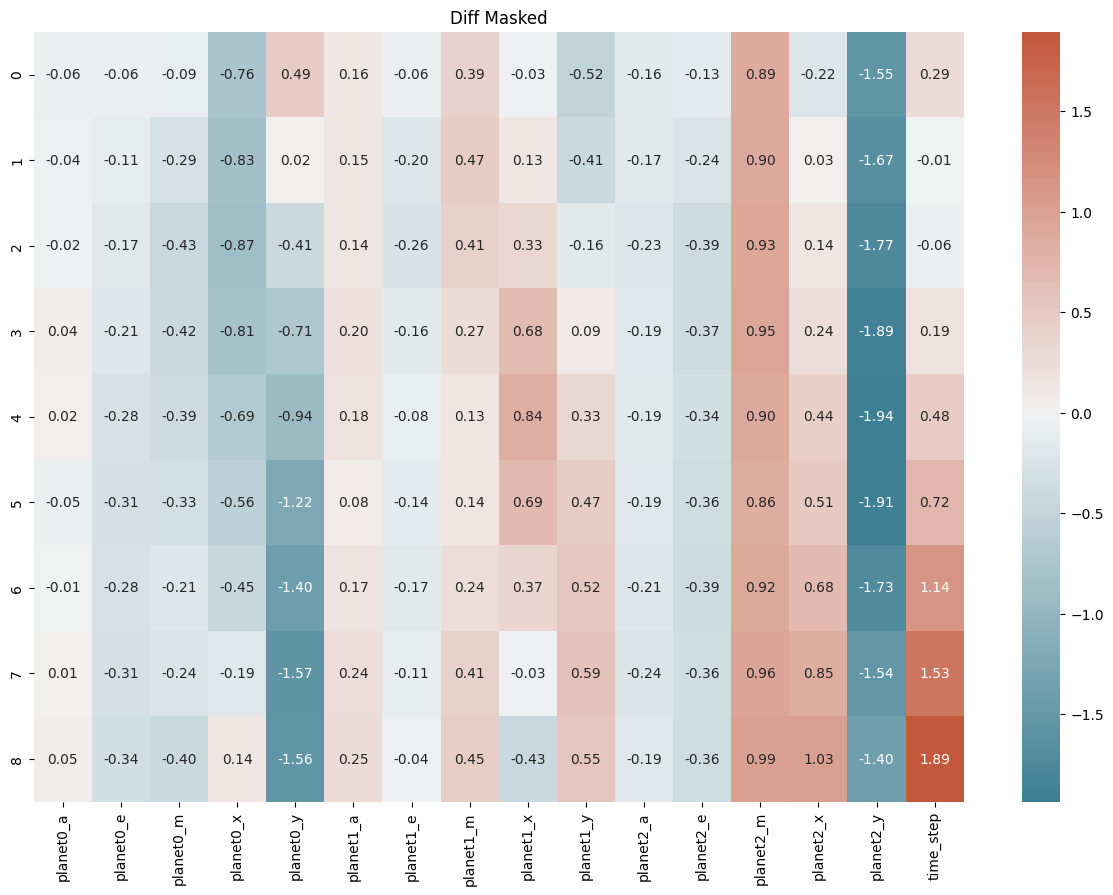

In [ ]:
def show_heatmap(df, title):
    """Shows heatmap for a dataframe
    excludes all columns that are only nan and all rows that are only nan"""

    df = df.dropna(axis=1, how="all")
    df = df.dropna(axis=0, how="all")
    plt.figure(figsize=(15, 10))
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    sns.heatmap(df, cmap=cmap, center=0, annot=True, fmt=".2f")
    plt.title(title)
    plt.show()


show_heatmap(res["diff_masked"], "Diff Masked")

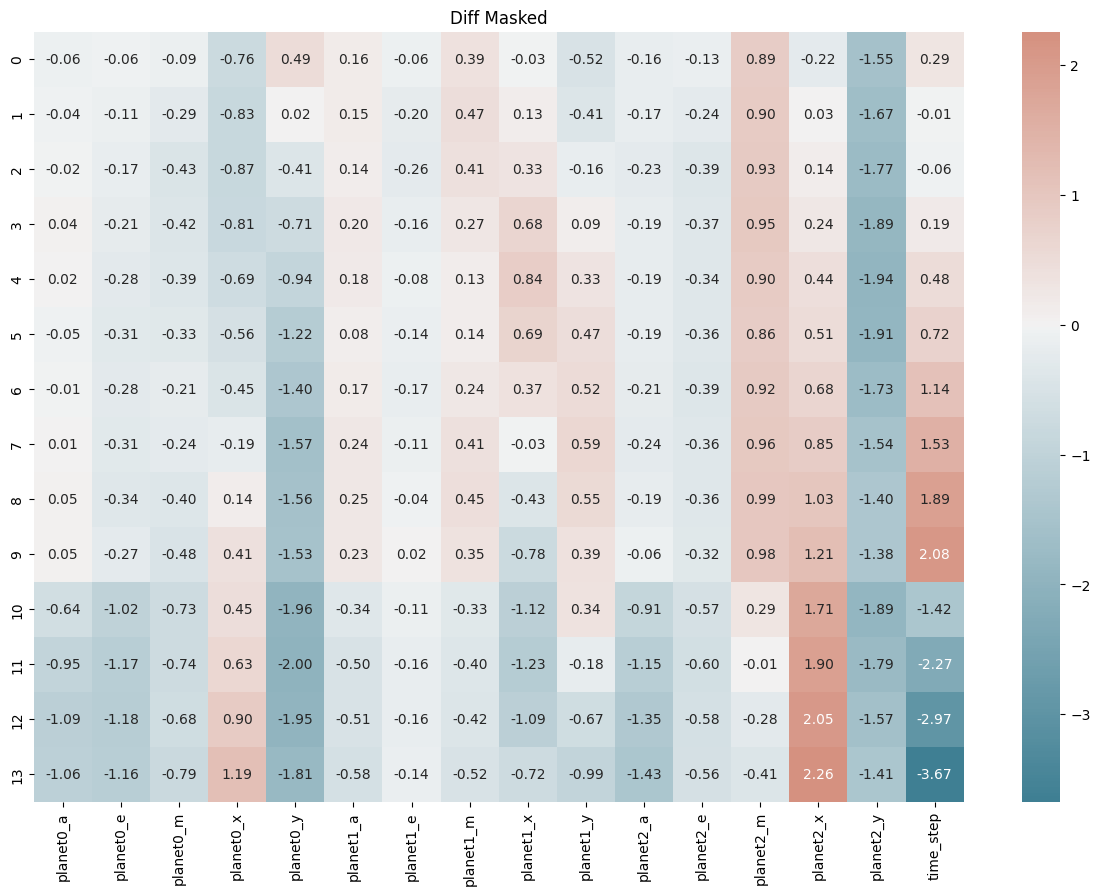

In [ ]:
show_heatmap(res["diff_no_mask"].head(14), "Diff Masked")

In [ ]:
test_key = random.PRNGKey(4454)
x = jax.random.normal(test_key, (4, 26, 59, 256))

In [ ]:
from flax import linen as nn

In [ ]:
test_ds[0][:10, :].shape

(10, 26)

In [ ]:
state.apply_fn(
    {"params": state.params},
    jnp.array([test_ds[0][:10, :]]),
    deterministic=True,
).shape

(1, 26, 10)

In [ ]:
def auto_regressive_predictions(
    state: train_state.TrainState, inputs: jnp.ndarray
) -> np.ndarray:
    # get the first row that contains all nan vales
    # if nan_rows_start >= stop_idx:
    #     return inputs
    nan_columns = jnp.isnan(inputs).all(axis=0)
    outputs = state.apply_fn(
        {"params": state.params},
        jnp.array([inputs]),
        deterministic=True,
    )
    outputs = jnp.squeeze(outputs)
    outputs = jnp.swapaxes(outputs, 0, 1)
    final_row = np.array(outputs[-1, :])

    inputs = jnp.concatenate([inputs, final_row[None, :]], axis=0)
    inputs = np.array(inputs)
    inputs[:, nan_columns] = np.nan
    return inputs
    # return auto_regressive_predictions(state, inputs, stop_idx)


inputs1 = test_ds[0][:10, :]
for i in trange(20):
    inputs1 = auto_regressive_predictions(state, inputs1)

# x = auto_regressive_predictions(state, test_ds[0], 10)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
# def auto_regressive_predictions(
#     state: train_state.TrainState, inputs: jnp.ndarray, stop_idx: int
# ) -> np.ndarray:
#     # get the first row that contains all nan vales
#     nan_rows_start = jnp.isnan(inputs).all(axis=1).argmax()
#     # if nan_rows_start >= stop_idx:
#     #     return inputs
#     nan_columns = jnp.isnan(inputs).all(axis=0)
#     outputs = state.apply_fn(
#         {"params": state.params},
#         jnp.array([inputs]),
#         deterministic=True,
#     )
#     outputs = jnp.squeeze(outputs)
#     outputs = jnp.swapaxes(outputs, 0, 1)
#     final_row = np.array(outputs[nan_rows_start])

#     inputs[nan_rows_start, :] = final_row
#     inputs[:, nan_columns] = np.nan
#     return inputs
#     # return auto_regressive_predictions(state, inputs, stop_idx)


# inputs1 = test_ds[0]
# inputs1[10:] = np.nan
# for i in range(20):
#     inputs1 = auto_regressive_predictions(state, inputs1, 44)

# # x = auto_regressive_predictions(state, test_ds[0], 10)

In [ ]:
df_auto = pd.DataFrame(inputs1)
df_actual = pd.DataFrame(test_ds[0])
df_auto.columns = train_df.columns[1:]
df_actual.columns = train_df.columns[1:]
df_diff = df_auto - df_actual

# Drop rows that are all nan
df_diff = df_diff.dropna(axis=0, how="all")

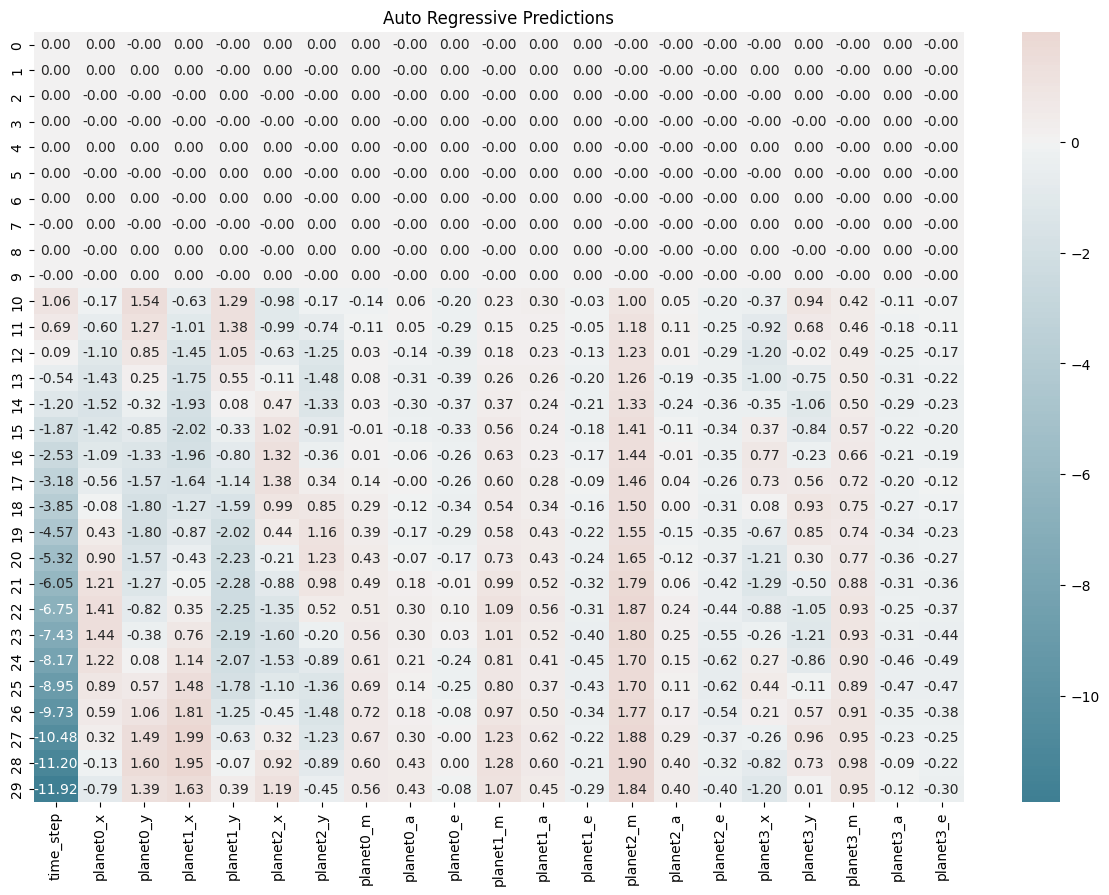

In [ ]:
show_heatmap(df_diff, "Auto Regressive Predictions")

In [ ]:
df_auto

,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,planet0_m,planet0_a,planet0_e,...,planet3_x,planet3_y,planet3_m,planet3_a,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e
0,0.000000,-0.274094,1.658928,-1.598680,1.237278,-0.072378,1.334127,3.092371,1.670390,1.413908,...,-0.819635,-0.591357,3.125578,1.000000,0.265969,NaN,NaN,NaN,NaN,NaN
1,0.733333,-0.810119,1.516448,-1.860540,0.797326,-0.675005,1.164327,3.092371,1.670390,1.413908,...,-0.221462,-0.977945,3.125578,1.000000,0.265969,NaN,NaN,NaN,NaN,NaN
2,1.466667,-1.261577,1.214381,-2.002381,0.305935,-1.131812,0.742120,3.092371,1.670390,1.413908,...,0.488067,-0.865076,3.125578,1.000000,0.265969,NaN,NaN,NaN,NaN,NaN
3,2.200000,-1.587840,0.791168,-2.015313,-0.205141,-1.347517,0.161522,3.092371,1.670390,1.413908,...,0.940597,-0.299916,3.125578,1.000000,0.265969,NaN,NaN,NaN,NaN,NaN
4,2.933333,-1.762252,0.291976,-1.898518,-0.702988,-1.278262,-0.453284,3.092371,1.670390,1.413908,...,0.892142,0.424392,3.125578,1.000000,0.265969,NaN,NaN,NaN,NaN,NaN
5,3.666667,-1.771421,-0.234710,-1.659290,-1.155468,-0.938204,-0.971871,3.092371,1.670390,1.413908,...,0.369250,0.923908,3.125578,1.000000,0.265969,NaN,NaN,NaN,NaN,NaN
6,4.400000,-1.614646,-0.739356,-1.312673,-1.533121,-0.397293,-1.281833,3.092371,1.670390,1.413908,...,-0.347699,0.942486,3.125578,1.000000,0.265969,NaN,NaN,NaN,NaN,NaN
7,5.133333,-1.303897,-1.173251,-0.880668,-1.810965,0.229908,-1.311548,3.092371,1.670390,1.413908,...,-0.889683,0.481951,3.125578,1.000000,0.265969,NaN,NaN,NaN,NaN,NaN
8,5.866667,-0.864351,-1.490723,-0.391028,-1.970130,0.805144,-1.048262,3.092371,1.670390,1.413908,...,-0.989130,-0.219265,3.125578,1.000000,0.265969,NaN,NaN,NaN,NaN,NaN
9,6.600000,-0.335132,-1.652404,0.124342,-1.999207,1.196205,-0.546035,3.092371,1.670390,1.413908,...,-0.597887,-0.811325,3.125578,1.000000,0.265969,NaN,NaN,NaN,NaN,NaN


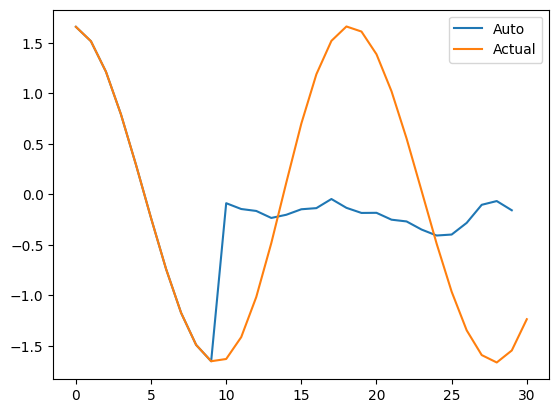

In [ ]:
# plot planet0_x from df_auto and df_actual
plt.plot(df_auto["planet0_y"], label="Auto")
plt.plot(df_actual["planet0_y"], label="Actual")
plt.legend()
plt.show()

In [27]:
# plot planet0_x from df_auto and df_actual
res = show_results_df(state, train_df, train_ds, idx=0, mask_start=50)
plt.plot(res["pred"]["planet0_y"], label="Auto")
plt.plot(res["actual_no_mask"]["planet0_y"], label="Actual")
plt.legend()
plt.show()

NameError: name 'show_results_df' is not defined